In this notebook we showcase openEO's standardization of remote sensing and Earth observation operations. We do this by translating the flood mapping algorithm as presented in @bauer-marschallinger_satellite-based_2022 to the openEO syntax of the Python Client. This algorithm employs Sentinel-1 backscattered microwaves, so-called "sigma nought" or $\sigma^0$, to detect flooding. In this exercise we will replicate the case study of the above mentioned paper, the February 2018 flooding of the Greek region of Thessaly.

## Setting-up a Python session

We begin by loading openEO and some additional packages. In this exercise we make use of a local variant of openEO as the data is not yet available on an accessible data store.


In [1]:
# from datetime import datetime
# from pathlib import Path
import numpy as np

import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import openeo

## Connect to the EODC openEO back-end

Establish a connection to the EODC backend with `openeo.connect()`. This results in a connection object which is a critical aspect of collection discovery on the back-end by openEO. 


In [2]:
backend = "https://openeo.eodc.eu" 
connection = openeo.connect(backend)
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.eodc.eu/openeo/1.1.0/' with OidcBearerAuth>

## Load collections

We can then load the collections. This is done by using the method `load_collection()` and by using the collection ids as defined above.


In [3]:
spatial_extent = {"west": 22, "south": 39.483774, "east": 22.225465, "north": 39.6}
sensing_date = ["2018-02-28T04:00:00Z", "2018-02-28T05:00:00Z"]

### Microwave Backscatter


In [4]:
connection.collection_metadata("SENTINEL1_SIG0_20M")

In [5]:
#| eval: false
sig0_dc = connection.load_collection(
    "SENTINEL1_SIG0_20M",
    spatial_extent = spatial_extent,
    temporal_extent = sensing_date,
    bands=["VV"]
)
sig0_res = sig0_dc.save_result(format = "NetCDF")
sig0_job = sig0_res.create_job(title = "sig0_greece_flood_2018_as_NetCDF_py")
sig0_job.start_job()
sig0_job.download_results()

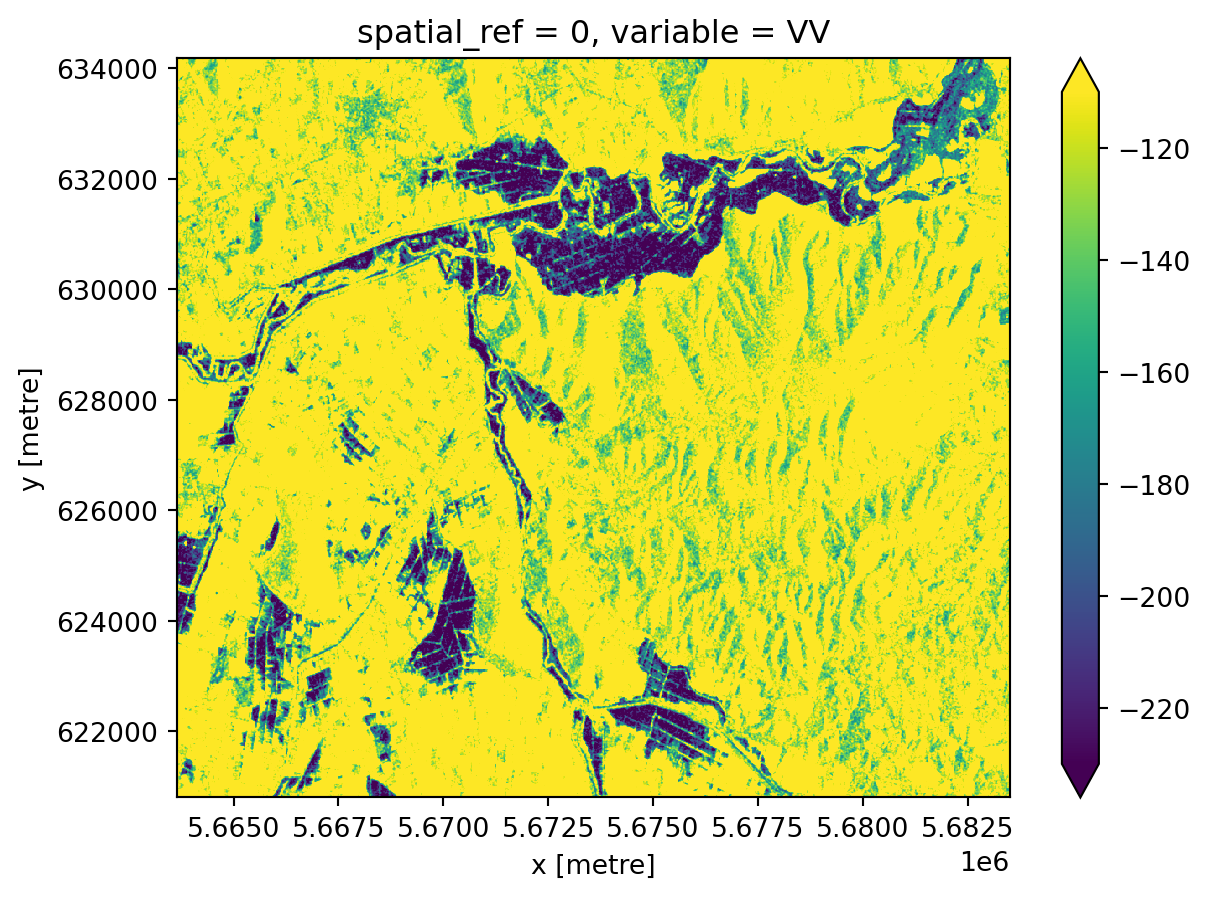

In [6]:
sig0_dc = xr .open_mfdataset("openEO_eodc/s1_parameters/SIG0/*.nc", concat_dim="time", combine='nested')
sig0_dc.where(sig0_dc != -9999). \
    mean(dim="time"). \
    to_array(). \
    plot(x="x", y="y", vmin=-230, vmax=-110)

### Harmonic parameters


In [7]:
connection.collection_metadata("SENTINEL1_HPAR")

In [8]:
#| eval: false
hparam_dc = connection.load_collection(
    "SENTINEL1_HPAR",
    spatial_extent = spatial_extent,
    temporal_extent = "2019"
)
hparam_res = hparam_dc.save_result(format = "NetCDF")
hparam_job = hparam_res.create_job(title = "hparam_greece_flood_2018_as_NetCDF_py")
hparam_job.start_job()
hparam_job.download_results()

In [9]:
hparam_dc = xr.open_mfdataset("openEO_eodc/tuw_s1_harpar/*.nc", concat_dim="time", combine='nested')
hparam_dc

<xarray.Dataset>
Dimensions:      (time: 1, y: 669, x: 993)
Coordinates:
  * y            (y) float64 6.342e+05 6.342e+05 ... 6.208e+05 6.208e+05
  * x            (x) float64 5.664e+06 5.664e+06 ... 5.683e+06 5.683e+06
    spatial_ref  int32 ...
    t            datetime64[ns] ...
    filepaths    float64 ...
Dimensions without coordinates: time
Data variables:
    C1           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    C2           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    C3           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    M0           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    S1           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    S2           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    S3           (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    STD          (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
    NOBS         (time, y, x) float32 dask.array<chunksize=(1, 669, 993), meta=np.ndarray>
Attributes:
    nodata:   -9999
    crs:      PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984"...

### Local Incidence Angle


In [10]:
connection.collection_metadata("SENTINEL1_MPLIA")

In [11]:
#| eval: false
plia_dc = connection.load_collection(
    "SENTINEL1_MPLIA",
    spatial_extent = spatial_extent,
    temporal_extent = ["2020-01-01", "2020-12-31"]
)
plia_res = plia_dc.save_result(format = "NetCDF")
plia_job = plia_res.create_job(title = "plia_greece_flood_2018_as_NetCDF_py")
plia_job.start_job()
plia_job.download_results()

In [12]:
plia_dc = xr.open_mfdataset("openEO_eodc/s1_parameters/PLIA-TAG/*.nc")
plia_dc

<xarray.Dataset>
Dimensions:      (y: 669, x: 993)
Coordinates:
  * y            (y) float64 6.342e+05 6.342e+05 ... 6.208e+05 6.208e+05
  * x            (x) float64 5.664e+06 5.664e+06 ... 5.683e+06 5.683e+06
    spatial_ref  int32 ...
    t            datetime64[ns] ...
    filepaths    float64 ...
Data variables:
    NOBS         (y, x) float32 dask.array<chunksize=(669, 993), meta=np.ndarray>
    MPLIA        (y, x) float32 dask.array<chunksize=(669, 993), meta=np.ndarray>
Attributes:
    nodata:   -9999
    crs:      PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984"...